In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
from tqdm import tqdm  # Ensure you have tqdm imported
from diffusion import Diffusion
class CustomDataset(Dataset):
    def __init__(self, images_dir, captions_file):
        self.images_dir = images_dir
        self.captions_df = pd.read_csv(captions_file)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758])
        ])

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        image_filename = str(self.captions_df.iloc[idx]["saved_image"]).strip()
        caption = str(self.captions_df.iloc[idx]["title"]).strip()
        
        image_path = os.path.join(self.images_dir, image_filename)
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        return {'image': image, 'caption': caption}

# Paths
images_dir = '/home/azureuser/dat/Stable_difusion/sd'  # Specify your images directory
captions_file = '/home/azureuser/dat/Stable_difusion/sd/dataset/data_with_images.csv'

# Initialize dataset and dataloader
dataset = CustomDataset(images_dir=images_dir, captions_file=captions_file)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [2]:
import torch
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split  # Optional if using the sklearn method

# Define dataset size and split ratio
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Example to verify the splits
print(f"Total samples: {dataset_size}, Training samples: {train_size}, Test samples: {test_size}")

Total samples: 897, Training samples: 717, Test samples: 180


In [12]:
from ddpm import DDPMSampler
import torch
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
WIDTH = 256
HEIGHT = 256
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def encoder_image(input_image_tensor, models, generator, device):
    encoder = models["encoder"]
    encoder.to(device)

    # (Batch_Size, 4, Latents_Height, Latents_Width)
    encoder_noise = torch.randn(input_image_tensor.shape, generator=generator, device=device)
    # (Batch_Size, 4, Latents_Height, Latents_Width)
    latents = encoder(input_image_tensor, encoder_noise)
    mean, log_variance = torch.chunk(latents, 2, dim=1)
    return mean

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=16, dtype=torch.float32) / 16) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

def compute_loss(outputs, targets):
    loss_fn = torch.nn.MSELoss()
    return loss_fn(outputs, targets)

def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_loss': best_val_loss
    }, checkpoint_path)

def save_losses_to_file(epoch, avg_train_loss, avg_val_loss, file_path, lr):
    with open(file_path, 'a') as file:
        file.write(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}, lr: {lr:.12f}\n")
checkpoint_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoints1202"
losses_file_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoints1202/losses.txt"
def train(
    diffusion,
    train_loader,
    val_loader,  # Validation loader
    optimizer,
    strength=0.8,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    tokenizer=None,
    start_epoch=0,
    num_epochs=10,
    checkpoint_dir='checkpoints1202'
):
    if not 0 < strength <= 1:
        raise ValueError("strength must be between 0 and 1")
    best_val_loss = 99
    # Initialize random number generator according to the seed specified
    generator = torch.Generator(device=device)
    if seed is None:
        generator.seed()
    else:
        generator.manual_seed(seed)

    clip = models["clip"]
    clip.to(device)

    if sampler_name == "ddpm":
        sampler = DDPMSampler(generator)
        sampler.set_inference_timesteps(n_inference_steps)
    else:
        raise ValueError("Unknown sampler value %s." % sampler_name)

    # Initialize the optimizer
    scaler = GradScaler()

    for epoch in range(start_epoch, num_epochs):
        diffusion.train()
        train_loss = 0.0

        # Training Loop
        for batch_idx, batch in enumerate(tqdm(train_loader)):
            images = batch['image'].to(device)
            captions = batch['caption']

            # Tokenize captions
            inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
            tokens = inputs['input_ids'].to(device)
            context = clip(tokens)

            timestep_losses = []
            timesteps = sampler.timesteps
            latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)
            latents = torch.randn(latents_shape, generator=generator, device=device)
            for timestep in timesteps:
                time_embedding = get_time_embedding(timestep).to(device)
                optimizer.zero_grad()

                _, model_output = diffusion(latents, context, time_embedding)
                # print(model_output.shape)
                # print(images.shape)
            with autocast():
                images = encoder_image(images, models, generator, device)
                loss = compute_loss(model_output, images)
                # Accumulate loss
                timestep_losses.append(loss.item())
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            # Compute average loss for the batch
            avg_batch_loss = sum(timestep_losses) / len(timestep_losses)
            train_loss += avg_batch_loss

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")

        # Validation Loop (Evaluation)
        diffusion.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                images = batch['image'].to(device)
                captions = batch['caption']

                inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
                tokens = inputs['input_ids'].to(device)
                context = clip(tokens)

                # Accumulate losses for each timestep
                timestep_losses = []
                timesteps = sampler.timesteps
                latents_val = torch.randn(latents_shape, generator=generator, device=device)
                for timestep in timesteps:
                    time_embedding = get_time_embedding(timestep).to(device)
                    _, model_output = diffusion(latents_val, context, time_embedding)
                    images = encoder_image(images, models, generator, device)
                    # output_cond, output_uncond = model_output.chunk(2)
                    # model_output = 0.75 * (output_cond - output_uncond) + output_uncond

                    loss = compute_loss(model_output, images)

                    # Accumulate loss
                    timestep_losses.append(loss.item())

                # Compute average loss for the batch
                avg_batch_loss = sum(timestep_losses) / len(timestep_losses)
                val_loss += avg_batch_loss

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}")

        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}, Learning Rate: {lr:.12f}")

        save_losses_to_file(epoch + 1, avg_train_loss, avg_val_loss, losses_file_path, lr)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path1 = f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}_val_loss_{best_val_loss:.4f}.pth"
            save_checkpoint(diffusion, optimizer, epoch + 1, best_val_loss, checkpoint_path1)

    final_checkpoint_path = f"{checkpoint_path}/checkpoint_epoch_{num_epochs}_val_loss_{best_val_loss:.4f}.pth"
    save_checkpoint(diffusion, optimizer, num_epochs, best_val_loss, final_checkpoint_path)



In [14]:
from diffusion import Diffusion
from torch.optim import AdamW
from transformers import CLIPTokenizer
import model_loader
device = "cuda"
DEVICE = "cuda"
diffusion = Diffusion().to(device)
seed = 42
optimizer = AdamW(diffusion.parameters(), lr=1e-4)

tokenizer = CLIPTokenizer("/home/azureuser/dat/Stable_difusion/sd/models/vocab.json", merges_file="/home/azureuser/dat/Stable_difusion/sd/models/merges.txt")
model_file = "/home/azureuser/dat/Stable_difusion/sd/models/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

train(
    diffusion,
    train_loader,
    test_loader,
    optimizer,
    strength=0.8,
    sampler_name="ddpm",
    n_inference_steps=25,
    models=models,
    seed=seed,
    device=device,
    tokenizer=tokenizer,
    start_epoch=0,
    num_epochs=1,
    checkpoint_dir='checkpoints1202'
)

/tmp/ipykernel_965377/1991177884.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/717 [00:00<?, ?it/s]/tmp/ipykernel_965377/1991177884.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 717/717 [11:11<00:00,  1.07it/s]


Epoch 1, Average Training Loss: 17.5664


RuntimeError: Given groups=1, weight of size [128, 3, 3, 3], expected input[1, 4, 32, 32] to have 3 channels, but got 4 channels instead

In [6]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from transformers import CLIPTokenizer
from diffusion import Diffusion
import model_loader
from ddpm import DDPMSampler

# Configuration
device = "cuda"
seed = 42
num_epochs = 10
lr = 1e-4
weight_decay = 0.01
losses_file_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoint_new_t2i/losses.txt"

# Initialize
torch.manual_seed(seed)
generator = torch.Generator(device=device)
generator.manual_seed(seed)

# CLIP Model and Tokenizer
tokenizer = CLIPTokenizer.from_pretrained("/home/azureuser/dat/Stable_difusion/sd/models")
model_file = "/home/azureuser/dat/Stable_difusion/sd/models/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, device)
clip = models['clip'].to(device)
diffusion = Diffusion().to(device)
checkpoint_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoint_new_t2i"
# Optimizer and Scheduler
optimizer = AdamW(
    diffusion.parameters(),
    lr=lr,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=weight_decay
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

def get_time_embedding(timestep):
    freqs = torch.pow(10000, -torch.arange(start=0, end=16, dtype=torch.float32) / 16)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

def compute_loss(outputs, targets):
    loss_fn = torch.nn.MSELoss()
    return loss_fn(outputs, targets)

def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_loss': best_val_loss
    }, checkpoint_path)

def save_losses_to_file(epoch, avg_train_loss, avg_val_loss, file_path, lr):
    with open(file_path, 'a') as file:
        file.write(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}, lr: {lr:.12f}\n")

def train(diffusion, train_loader, val_loader, tokenizer, optimizer, checkpoint_path, start_epoch=0, best_val_loss=99, num_epochs=num_epochs):
    scaler = GradScaler()
    sampler = DDPMSampler(generator)
    sampler.set_inference_timesteps(25)
    latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)
    for epoch in range(start_epoch, num_epochs):
        diffusion.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(tqdm(train_loader)):
            images = batch['image'].to(device)
            captions = batch['caption']

            # Tokenize captions
            inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
            tokens = inputs['input_ids'].to(device)
            context = clip(tokens)

            # Accumulate losses for each timestep
            timestep_losses = []
            timesteps = sampler.timesteps
            latents = torch.randn(latents_shape, generator=generator, device=device)
            for timestep in timesteps:
                time_embedding = get_time_embedding(timestep).to(device)
                optimizer.zero_grad()

                _, model_output = diffusion(latents, context, time_embedding)
                # print(model_output.shape)
                # print(images.shape)
            with autocast():
                loss = compute_loss(model_output, images)
            
                # Accumulate loss
                timestep_losses.append(loss.item())
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            # Compute average loss for the batch
            avg_batch_loss = sum(timestep_losses) / len(timestep_losses)
            train_loss += avg_batch_loss

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        diffusion.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                images = batch['image'].to(device)
                captions = batch['caption']

                inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
                tokens = inputs['input_ids'].to(device)
                context = clip(tokens)

                # Accumulate losses for each timestep
                timestep_losses = []
                timesteps = sampler.timesteps
                latents_val = torch.randn(latents_shape, generator=generator, device=device)
                for timestep in timesteps:
                    time_embedding = get_time_embedding(timestep).to(device)
                    _, model_output = diffusion(latents_val, context, time_embedding)

                    # output_cond, output_uncond = model_output.chunk(2)
                    # model_output = 0.75 * (output_cond - output_uncond) + output_uncond

                    loss = compute_loss(model_output, images)

                    # Accumulate loss
                    timestep_losses.append(loss.item())

                # Compute average loss for the batch
                avg_batch_loss = sum(timestep_losses) / len(timestep_losses)
                val_loss += avg_batch_loss

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}")

        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}, Learning Rate: {lr:.12f}")

        save_losses_to_file(epoch + 1, avg_train_loss, avg_val_loss, losses_file_path, lr)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path1 = f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}_val_loss_{best_val_loss:.4f}.pth"
            save_checkpoint(diffusion, optimizer, epoch + 1, best_val_loss, checkpoint_path1)

        scheduler.step(avg_val_loss)

    final_checkpoint_path = f"{checkpoint_path}/checkpoint_epoch_{num_epochs}_val_loss_{best_val_loss:.4f}.pth"
    save_checkpoint(diffusion, optimizer, num_epochs, best_val_loss, final_checkpoint_path)

# Start training
# Assuming train_loader and val_loader are already defined
def load_checkpoint(checkpoint_path, model, optimizer, device="cuda"):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load state dicts into the model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Retrieve additional information
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    
    print(f"Checkpoint loaded: Epoch {epoch}, Best Validation Loss: {best_val_loss:.4f}")
    
    return model, optimizer, epoch, best_val_loss
# checkpoint_path2 = '/home/azureuser/dat/Stable_difusion/sd/checkpoint_new_t2i/checkpoint_epoch_51_val_loss_0.0309.pth'
# model, optimizer, epoch, best_val_loss = load_checkpoint(checkpoint_path2, diffusion, optimizer, device="cuda")
train(diffusion, train_loader, test_loader, tokenizer, optimizer, checkpoint_path, start_epoch=0, best_val_loss=99, num_epochs=50)


/home/azureuser/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


/home/azureuser/anaconda3/envs/py310/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_791182/2331987685.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/717 [00:00<?, ?it/s]/tmp/ipykernel_791182/2331987685.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/azureuser/anaconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([1, 4, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduc

RuntimeError: The size of tensor a (32) must match the size of tensor b (256) at non-singleton dimension 3

In [8]:
save_checkpoint(diffusion, optimizer, num_epochs, 0.0893, '/home/azureuser/dat/Stable_difusion/sd/checkpoint_new_t2i/final.pth')

/tmp/ipykernel_618774/4124134754.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


/tmp/ipykernel_618774/4124134754.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded: Epoch 2, Best Validation Loss: 0.0680
1


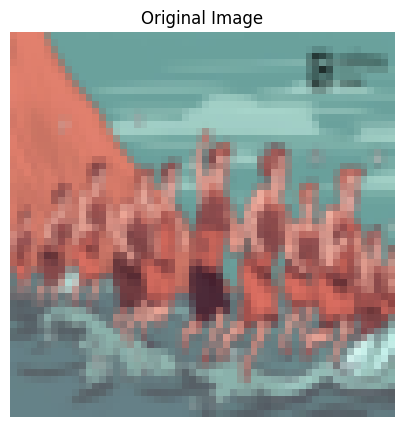

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36847332..1.3041527].


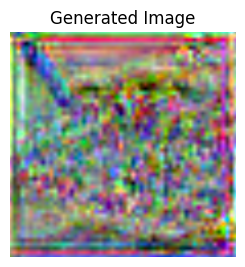

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36847332..1.3041527].


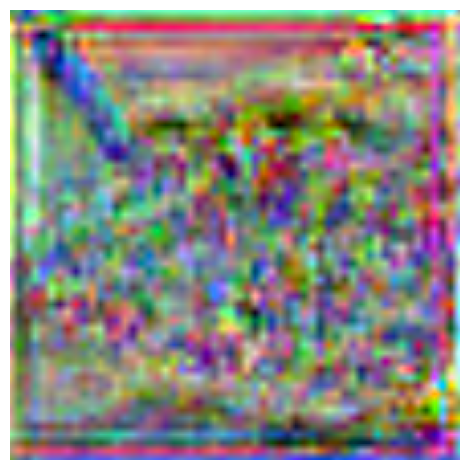

In [10]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from ddpm import DDPMSampler
from diffusion import Diffusion
from torch.optim import AdamW
from transformers import CLIPTokenizer
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from transformers import CLIPTokenizer
from diffusion import Diffusion
import model_loader
from ddpm import DDPMSampler
scaler = GradScaler()
seed = 42
device = "cuda"
generator = torch.Generator(device=device)
if seed is None:
    generator.seed()
else:
    generator.manual_seed(seed)
sampler = DDPMSampler(generator)
sampler.set_inference_timesteps(25)
# CLIP Model and Tokenizer
tokenizer = CLIPTokenizer.from_pretrained("/home/azureuser/dat/Stable_difusion/sd/models")
model_file = "/home/azureuser/dat/Stable_difusion/sd/models/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, device)
clip = models['clip'].to(device)
diffusion = Diffusion().to(device)
checkpoint_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoint_new/checkpoint_epoch_90_val_loss_0.0281.pth"
# Function to load the checkpoint correctly
def load_checkpoint(checkpoint_path, model, optimizer, device="cuda"):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Best Validation Loss: {best_val_loss:.4f}")
    return model, optimizer, epoch, best_val_loss

# Initialize the diffusion model
diffusion = Diffusion().to(device)

# Set optimizer
lr = 1e-4
weight_decay = 0.01
optimizer = AdamW(
    diffusion.parameters(),
    lr=lr,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=weight_decay
)

# Load the checkpoint
checkpoint_path2 = '/home/azureuser/dat/Stable_difusion/sd/checkpoint_new_t2i/checkpoint_epoch_2_val_loss_0.0680.pth'
model, optimizer, epoch, best_val_loss = load_checkpoint(checkpoint_path2, diffusion, optimizer, device=device)

# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze()  # Remove batch dimension if present
    if tensor.ndim == 3 and tensor.shape[0] == 3:  # Color image
        tensor = tensor.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
    return tensor.cpu().numpy()

# Function to display an image from tensor
def show_image_from_tensor(tensor, title=None, normalize=False, cmap='viridis'):
    # Convert tensor to (H, W, C) format if needed
    if tensor.dim() == 4 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
    if tensor.dim() == 3 and tensor.size(0) in {1, 3}:
        tensor = tensor.permute(1, 2, 0)
    
    # Normalize tensor if required
    if normalize:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    # Display image
    if tensor.dim() == 2 or tensor.size(-1) == 1:
        plt.imshow(tensor.cpu().numpy(), cmap=cmap)
    else:
        plt.imshow(tensor.cpu().numpy())

    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Set the model to evaluation mode
diffusion.eval()

import torch.functional as F
# Plotting images with titles and display settings
plt.figure(figsize=(64, 5))  # Adjust size for side-by-side images
def get_time_embedding(timestep):
    freqs = torch.pow(10000, -torch.arange(start=0, end=16, dtype=torch.float32) / 16)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)
# Iterate through the test_loader and run inference to get outputs for the first batch only

def save_image_from_tensor(tensor, filename, normalize=False, cmap='viridis'):
    # Convert tensor to (H, W, C) format if needed
    if tensor.dim() == 4 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
    if tensor.dim() == 3 and tensor.size(0) in {1, 3}:
        tensor = tensor.permute(1, 2, 0)
    
    # Normalize tensor if required
    if normalize:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    # Save image
    plt.imshow(tensor.cpu().numpy(), cmap=cmap)
    plt.axis('off')
    plt.savefig(filename)

for batch_idx, batch in enumerate(test_loader):
    images = batch['image'].to(device)
    captions = batch['caption']
    
    # Tokenize captions and get context
    inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
    tokens = inputs['input_ids'].to(device)
    context = clip(tokens)

    # Generate outputs with the model
    with torch.no_grad():
        timesteps = sampler.timesteps
        latents = torch.randn(2, 3, 56, 56).to(device)
        for timestep_idx, timestep in enumerate(timesteps):
            # Get time embedding for current timestep
            time_embedding = get_time_embedding(timestep).to(device)

            # Forward pass through the diffusion model to get predicted noise
            _, model_output = diffusion(images, context, time_embedding)

            # Combine conditional and unconditional outputs
            # output_cond, output_uncond = model_output.chunk(2)
            # model_output = 0.75 * (output_cond - output_uncond) + output_uncond
            
        model_output = torch.nn.functional.interpolate(model_output, size=(256, 256), mode='bilinear', align_corners=True)
        # Plot original and generated images
        # plt.subplot(1, 2, 1)
        # show_image_from_tensor(latent[0], title='latent Image')
        print(context.shape[0])
        plt.subplot(1, 2, 1)
        show_image_from_tensor(images[0], title='Original Image')
        plt.subplot(1, 2, 2)
        show_image_from_tensor(model_output[0], title='Generated Image')
        save_image_from_tensor(model_output[0], 'generated_image.png')
            

    break

plt.tight_layout()
plt.show()


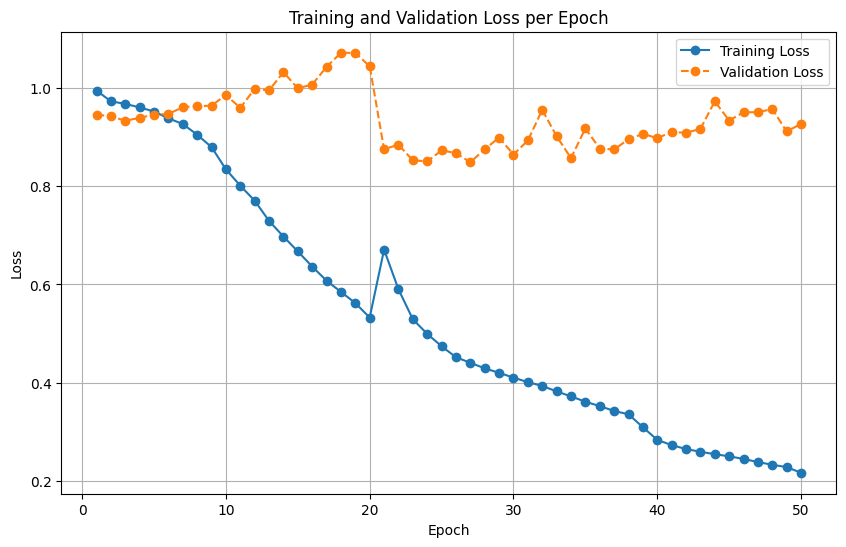

In [6]:
import matplotlib.pyplot as plt

# Data for the epochs
epochs = list(range(1, 51))
train_loss = [
    0.9946, 0.9728, 0.9675, 0.9604, 0.9520, 0.9381, 0.9266, 0.9048, 0.8796, 0.8343,
    0.8010, 0.7705, 0.7293, 0.6975, 0.6672, 0.6364, 0.6075, 0.5848, 0.5620, 0.5325,
    0.6708, 0.5901, 0.5291, 0.4993, 0.4741, 0.4517, 0.4404, 0.4291, 0.4200, 0.4102,
    0.4010, 0.3933, 0.3822, 0.3720, 0.3612, 0.3522, 0.3424, 0.3355, 0.3093, 0.2834,
    0.2729, 0.2648, 0.2593, 0.2543, 0.2500, 0.2446, 0.2383, 0.2328, 0.2280, 0.2166
]

val_loss = [
    0.9454, 0.9425, 0.9331, 0.9392, 0.9458, 0.9469, 0.9609, 0.9629, 0.9639, 0.9858,
    0.9593, 0.9982, 0.9951, 1.0321, 0.9992, 1.0070, 1.0428, 1.0717, 1.0712, 1.0442,
    0.8754, 0.8843, 0.8527, 0.8504, 0.8728, 0.8674, 0.8485, 0.8753, 0.8988, 0.8644,
    0.8930, 0.9554, 0.9017, 0.8571, 0.9176, 0.8766, 0.8748, 0.8954, 0.9065, 0.8979,
    0.9102, 0.9088, 0.9165, 0.9728, 0.9337, 0.9503, 0.9507, 0.9569, 0.9115, 0.9268
]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='--')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_562739/3006919829.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded: Epoch 51, Best Validation Loss: 0.6296


1


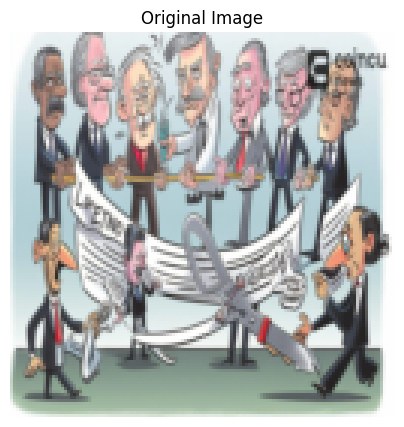

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05270917..1.6427147].


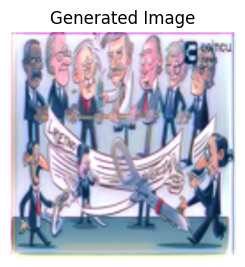

<Figure size 640x480 with 0 Axes>

In [6]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from ddpm import DDPMSampler
from diffusion import Diffusion
from torch.optim import AdamW
from transformers import CLIPTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import model_loader

device = "cpu"  # Thay đổi thiết bị từ 'cuda' sang 'cpu'
scaler = None  # Không cần sử dụng GradScaler cho CPU
seed = 42
generator = torch.Generator(device=device)

if seed is None:
    generator.seed()
else:
    generator.manual_seed(seed)

sampler = DDPMSampler(generator)
sampler.set_inference_timesteps(25)

# CLIP Model and Tokenizer
tokenizer = CLIPTokenizer.from_pretrained("/home/azureuser/dat/Stable_difusion/sd/models")
model_file = "/home/azureuser/dat/Stable_difusion/sd/models/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, device)
clip = models['clip'].to(device)
diffusion = Diffusion().to(device)
checkpoint_path = "/home/azureuser/dat/Stable_difusion/sd/checkpoint_new/checkpoint_epoch_90_val_loss_0.0281.pth"

# Function to load the checkpoint correctly
def load_checkpoint(checkpoint_path, model, optimizer, device="cpu"):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Best Validation Loss: {best_val_loss:.4f}")
    return model, optimizer, epoch, best_val_loss

# Set optimizer
lr = 1e-4
weight_decay = 0.01
optimizer = AdamW(
    diffusion.parameters(),
    lr=lr,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=weight_decay
)

# Load the checkpoint
checkpoint_path2 = '/home/azureuser/dat/Stable_difusion/sd/checkpoint/checkpoint_epoch_51_val_loss_0.6296.pth'
model, optimizer, epoch, best_val_loss = load_checkpoint(checkpoint_path2, diffusion, optimizer, device=device)

# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze()
    if tensor.ndim == 3 and tensor.shape[0] == 3:  
        tensor = tensor.permute(1, 2, 0)
    return tensor.cpu().numpy()

# Function to display an image from tensor
def show_image_from_tensor(tensor, title=None, normalize=False, cmap='viridis'):
    if tensor.dim() == 4 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
    if tensor.dim() == 3 and tensor.size(0) in {1, 3}:
        tensor = tensor.permute(1, 2, 0)
    
    if normalize:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    if tensor.dim() == 2 or tensor.size(-1) == 1:
        plt.imshow(tensor.cpu().numpy(), cmap=cmap)
    else:
        plt.imshow(tensor.cpu().numpy())

    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Set the model to evaluation mode
diffusion.eval()

# Resize transform to resize images to 128x128
resize_transform = T.Resize((128, 128))

plt.figure(figsize=(15, 5))
def get_time_embedding(timestep):
    freqs = torch.pow(10000, -torch.arange(start=0, end=16, dtype=torch.float32) / 16)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)
from tqdm import tqdm
# Iterate through the test_loader and run inference to get outputs for the first batch only
for batch_idx, batch in enumerate(test_loader):
    images = batch['image'].to(device)
    captions = batch['caption']
    
    # Tokenize captions and get context
    inputs = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
    tokens = inputs['input_ids'].to(device)
    context = clip(tokens)

    with torch.no_grad():
        timesteps = sampler.timesteps
        latents = torch.randn(2, 3, 56, 56).to(device)
        for timestep_idx, timestep in enumerate(tqdm(timesteps, desc="Timestep Progress", leave=False)):
            time_embedding = get_time_embedding(timestep).to(device)
            _, model_output = diffusion(images, context, time_embedding)

        model_output = torch.nn.functional.interpolate(model_output, size=(256, 256), mode='bilinear', align_corners=True)
        
        print(context.shape[0])
        plt.subplot(1, 2, 1)
        show_image_from_tensor(images[0], title='Original Image')
        plt.subplot(1, 2, 2)
        show_image_from_tensor(model_output[0], title='Generated Image')

    break

plt.tight_layout()
plt.show()


In [13]:
!git clone https://github.com/tzutalin/labelImg

Cloning into 'labelImg'...
remote: Enumerating objects: 2097, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2097 (delta 0), reused 5 (delta 0), pack-reused 2090 (from 1)
Receiving objects: 100% (2097/2097), 237.14 MiB | 74.88 MiB/s, done.
Resolving deltas: 100% (1245/1245), done.


In [25]:
!pip install PyQt5

In [16]:
!make qt5py3

make: *** No rule to make target 'qt5py3'.  Stop.


In [24]:
!pyrcc5 -o /home/azureuser/dat/labelImg/libs/resources.py resources.qrc

/home/azureuser/anaconda3/envs/py310/bin/pyrcc5: File does not exist 'resources.qrc'


In [9]:
import torch

device = "cuda"
generator = torch.Generator(device=device)
latents_shape = (1, 4, 64, 64)
latents = torch.randn(latents_shape, generator=generator, device=device)

# Kiểm tra nếu có bất kỳ phần tử nào lớn hơn 1
if (latents > 5).any():
    print(latents)


tensor([[[[0.3653, 0.6515, 0.4863,  ..., 0.6281, 0.4408, 0.5083],
          [0.5847, 0.4187, 0.2695,  ..., 0.5428, 0.3337, 0.5473],
          [0.3852, 0.6355, 0.4660,  ..., 0.5417, 0.5923, 0.3460],
          ...,
          [0.5707, 0.5638, 0.2904,  ..., 0.4669, 0.5685, 0.6222],
          [0.5616, 0.4557, 0.6471,  ..., 0.5088, 0.5405, 0.4488],
          [0.4487, 0.4475, 0.6306,  ..., 0.3729, 0.6204, 0.7750]],

         [[0.4755, 0.4559, 0.1568,  ..., 0.5017, 0.5250, 0.5147],
          [0.5418, 0.4806, 0.6675,  ..., 0.5161, 0.5492, 0.4496],
          [0.2863, 0.3632, 0.7054,  ..., 0.6108, 0.3739, 0.3341],
          ...,
          [0.7481, 0.4134, 0.3813,  ..., 0.5385, 0.5528, 0.6889],
          [0.3772, 0.4229, 0.4087,  ..., 0.5116, 0.3288, 0.4467],
          [0.4835, 0.4867, 0.3205,  ..., 0.4348, 0.6447, 0.5010]],

         [[0.4653, 0.3622, 0.5623,  ..., 0.5279, 0.6263, 0.5407],
          [0.6484, 0.5842, 0.5289,  ..., 0.4130, 0.4358, 0.4993],
          [0.4028, 0.5058, 0.7036,  ..., 0